Sending Connection: tcp://127.0.0.1:5023
Result Connection: tcp://127.0.0.1:5033
No directory for run...Creating now.

About to start exp: test 
	 run: _5
Press enter to run
Waiting Result
Recv'd Result
Run log created.
Log saved!
Preparing plot 2...
      Actual Speed  Goal Speed  Goal Status     Ori W     Ori X     Ori Y  \
0         0.000000    0.000000          0.0  0.000000  0.000000  0.000000   
1         2.133013    4.018289          0.0  0.921181  0.005650 -0.007731   
2         2.346273    4.022398          0.0  0.921032  0.005673 -0.007351   
3         2.678319    4.022398          0.0  0.921001  0.006648 -0.007009   
4         2.926621    4.011628          0.0  0.919875  0.007164 -0.007937   
5         3.133208    4.016327          0.0  0.919243  0.005453 -0.007423   
6         3.597949    4.011414          0.0  0.919036  0.004279 -0.004855   
7         3.645727    4.013839          0.0  0.918747  0.003158 -0.002362   
8         3.908009    3.999035          0.0  0.917355  0

Saving plot 2
Plots saved!
Email notification sent!


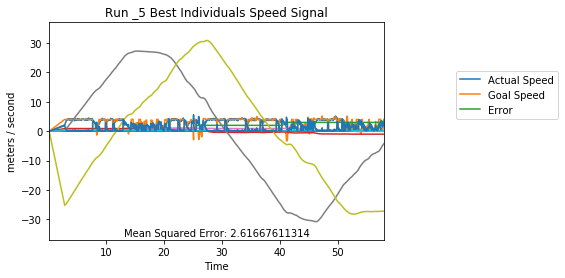

In [43]:
#
# GAS 11-06-18


# For command line argument parsing
import argparse

# For communication with evo_ros2
import zmq

# For data / fitness evaluation
import pandas as pd
from sklearn.metrics import mean_squared_error

# For DEAP
import random
from deap import creator, base, tools, algorithms
import numpy as np

# For email notifications
import smtplib
from email.mime.text import MIMEText

# For showing DEAP plots
import matplotlib.pyplot as plt
import networkx

# For EA running time
import time

# For creating directories and saving logs
import os
from os import listdir
from os.path import isfile, join
import json
import collections
import datetime

# For saving plots
import pickle

# For multiple evaluations at once
import threading

import pprint


class DEAP_EA():
	def __init__(self, cmd_args):
		self.debug = cmd_args.debug
		
		# EA Params
		self.experiment_name = "test"
		self.run_number = '_5'
		self.ind = [0.3, 0.06, 0.1, 0.05, 0.01, 0.02, 0.1, 0.5] #default
		
		
		# Socket Communication Params      
		self.ip_addr = '127.0.0.1'
		#self.ip_addr = '35.9.28.201'
		self.send_port = 5023
		self.recv_port = 5033

		# Email Notification Params
		self.email_receiver_list = ['glen.a.simon@gmail.com']
		
		# Multi-threading Params
		self.lock = threading.Lock()
		
		
		try:
			 # Set up 
			self.detailed_log = dict()
			self.set_up_sockets()
			self.set_up_dirs()
			
			print('\nAbout to start exp: {} \n\t run: {}'.format(self.experiment_name, self.run_number))
			raw_input("Press enter to run")
		
			# Run
			self.run()
		finally:
			self.socket.close()
			self.receiver.close()
			self.context.destroy()
		
	
	
	### Run the EA ###
	def run(self):
		
		self.socket.send_json(self.ind)
		
		print('Waiting Result')

		return_data = dict(self.receiver.recv_json())
		ind = list(return_data['Genome'])
		result = dict(return_data['Result'])
		fitness = self.evaluate_result(ind, result)
		
		# Final logging and notifications
		self.create_run_log()
		print('Run log created.')
		self.write_run_log()
		print('Log saved!')
		self.create_run_plots()
		print('Plots saved!')
		print('Email notification sent!')
	
	


	
	def evaluate_result(self, ind, result):
		print('Recv\'d Result')
		self.df = pd.DataFrame.from_dict(dict(result))
		self.df['Error'] = abs(self.df['Actual Speed'] - self.df['Goal Speed'])
		#df.plot(x='Time')
		self.fitness = mean_squared_error(self.df['Actual Speed'],  self.df['Goal Speed'])
		
		return (self.fitness, )
			
		

	### Set up communication sockets ###
	def set_up_sockets(self):
		#Initialize the socket for data
		
		# Setup the socket to send data out on.
		self.context = zmq.Context()
		self.socket = self.context.socket(zmq.PUSH)
		#socket.setsockopt(zmq.LINGER, 0)    # discard unsent messages on close
		self.socket.bind('tcp://{}:{}'.format(self.ip_addr, self.send_port))

		# Setup the socket to read the responses on.
		self.receiver = self.context.socket(zmq.PULL)
		self.receiver.bind('tcp://{}:{}'.format(self.ip_addr, self.recv_port))
		
		print('Sending Connection: {}'.format('tcp://{}:{}'.format(self.ip_addr, self.send_port)))
		print('Result Connection: {}'.format('tcp://{}:{}'.format(self.ip_addr, self.recv_port)))

	   
	
	### Create Experiment and Run directories if not already made ###
	def set_up_dirs(self):
		
		# Make sure that a directory for this experiment has been made
		self.experiment_directory = 'logs/' + self.experiment_name
		if not os.path.isdir(self.experiment_directory):
			print('No directory for experiment...Creating now.')
			os.makedirs(self.experiment_directory)
			
		# Make sure that a directory for this run has been made
		self.run_directory = self.experiment_directory + '/run' + str(self.run_number)
		if not os.path.isdir(self.run_directory):
			print('No directory for run...Creating now.')
			os.makedirs(self.run_directory)
			
	### Create the run log ###
	def create_run_log(self):
		self.run_log = collections.OrderedDict()
		
		self.run_log['experiment_name'] = self.experiment_name
		self.run_log['run_number'] = self.run_number
		self.run_log['run_date'] = str(datetime.datetime.now())
		self.run_log['best_ind'] = self.ind
		self.run_log['best_ind_fitness'] = self.fitness
		self.run_log['detailed_log'] = self.df.to_json()
		
		
	### Write the run log to disk ###
	def write_run_log(self):
		with open(self.run_directory + '/log' + '.json', 'w+') as outfile:
			json.dump(self.run_log, outfile, indent=2)
		self.df.to_csv(self.run_directory + '/out.csv')
		
		
	### Create run plots ###
	def create_run_plots(self):
		
		
		# Speed Signal of Best Ind
		print('Preparing plot 2...')
		details_of_best_ind = self.df
		self.df = self.df.sort_index()
		
		pp = pprint.PrettyPrinter(indent=4)
		pp.pprint(self.df)
		
		ax2 = self.df.plot(x='Time')
		ax2.legend(['Actual Speed', 'Goal Speed', 'Error'], bbox_to_anchor=(1.2, 0.8))
		ax2.set_title('Run {} Best Individuals Speed Signal'.format(self.run_number))
		plt.ylabel('meters / second')
		plt.text(0.5, 0.03, 'Mean Squared Error: {}'.format(self.fitness), horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
		fig2 = ax2.get_figure()
		plt.margins(x = 0.0, y = 0.1)
		print('Saving plot 2')
		fig2.savefig('{}/best_ind_speed_plot.png'.format(self.run_directory), bbox_inches='tight')
		
	
	

if __name__ == '__main__':
	# Parse arguments
	parser = argparse.ArgumentParser(description='Front end DEAP EA for PID Study')
	parser.add_argument('-d', '--debug', action='store_true', help='Print extra output to terminal.')
	args, unknown = parser.parse_known_args() # Only parse arguments defined above

	node = DEAP_EA(cmd_args = args)


In [ ]:
# Get rid of first all 0s entry
node.df = node.df.truncate(before=2)

# Speeds
avg_speed = node.df['Actual Speed'].mean()
max_speed = node.df['Actual Speed'].max()
norm_avg_speed = avg_speed / 26.82
norm_max_speed = max_speed / 26.82

# Waypoints
waypoints_achieved = node.df['Goal Status'].max()
norm_wp = waypoints_achieved / 4.0

if norm_wp == 1.0:
    # Time
    time_elapsed = node.df['Time'].max()
    norm_time_elapsed =  15.2 / time_elapsed

    # Distance
    dx = np.diff(node.df['Pos X'])
    dy = np.diff(node.df['Pos Y'])
    d = np.hypot(dx, dy)
    d = np.insert(d,0,0)
    total_distance = np.sum(d)
    norm_distance = 152.67 / total_distance

else:
    # Time
    time_elapsed = node.df['Time'].max()
    norm_time_elapsed =  time_elapsed / 300.0

    # Distance
    dx = np.diff(node.df['Pos X'])
    dy = np.diff(node.df['Pos Y'])
    d = np.hypot(dx, dy)
    d = np.insert(d,0,0)
    total_distance = np.sum(d)
    norm_distance = (total_distance / 222) / 2

fitness = [norm_avg_speed, norm_max_speed, norm_wp, norm_time_elapsed, norm_distance]
total_fitness = sum(fitness)
print(fitness)
print(total_fitness)
print(time_elapsed)
